# Bimodal Distribution
C. Heiser, 2019

---
__The purpose of this notebook is to test UMAP's propensity for outperforming t-SNE under very specific conditions.  Here, we are generating exaggerated bimodal distributions of cell-cell distances to give large populations of *large* and *small* distances for UMAP to optimize "more effectively" using cross-entropy as opposed to t-SNE's Kullback-Leibler (KL) Divergence.__  

We are using an *n*-dimensional Gaussian dataset built using `sklearn.datasets.make_gaussian_quantiles()`.

In [1]:
import sys
sys.path.append('../')
from fcc_utils import *

In [2]:
from sklearn import datasets # for swiss roll dataset
import mpl_toolkits.mplot3d.axes3d as p3 # 3D plotting

In [3]:
# ignore numba deprecation warnings given by sc.pp.neighbors()
import numba
import warnings
warnings.simplefilter('ignore', numba.errors.NumbaWarning)
warnings.simplefilter('ignore', numba.errors.NumbaDeprecationWarning)
warnings.simplefilter('ignore', numba.errors.NumbaPerformanceWarning)

In [4]:
# create dictionary for dumping results into
final_distance_stats = {
    'Gauss':{'R':{}, 'EMD':{}, 'Knn Pres.':{}}
                       }

---
### 1K-Point Gaussian Point-Clouds

In [25]:
X, t = datasets.make_gaussian_quantiles(cov=100, n_samples=1000, n_features=3, random_state=1)

In [26]:
X[:,0] = X[:,0] + 150

In [27]:
X2, t2 = datasets.make_gaussian_quantiles(cov=100, n_samples=1000, n_features=3, random_state=2)

In [28]:
X3 = np.append(X2, values=X, axis=0)

In [29]:
t3 = np.append(t2, values=t, axis=0)

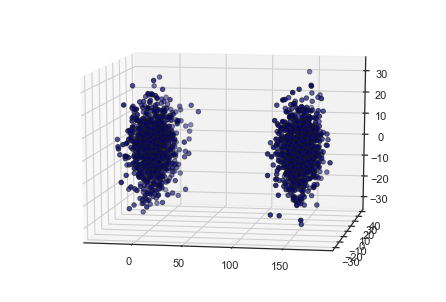

In [30]:
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(12, -80)
ax.scatter(X3[:, 0], X3[:, 1], X3[:, 2], color=plt.cm.jet(t3), s=20, edgecolor='k')

In [31]:
gauss = sc.AnnData(X=X3) # initialize AnnData
gauss.obs['class'] = t3 # add univariate position according to main dim of manifold to .obs
gauss

AnnData object with n_obs × n_vars = 2000 × 3 
    obs: 'class'

In [32]:
# perform PCA
%time sc.tl.pca(gauss, n_comps=2)

CPU times: user 6.07 ms, sys: 2.03 ms, total: 8.1 ms
Wall time: 2.3 ms


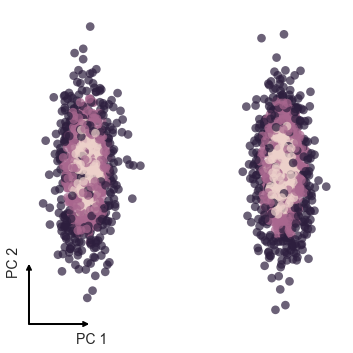

In [33]:
DR_plot(dim_name='PC').plot(gauss.obsm['X_pca'], color=gauss.obs['class'])

In [34]:
# create neighborhood graphs from PCA results for UMAP
%time sc.pp.neighbors(gauss, n_neighbors=30, use_rep='X', knn=True, random_state=18, metric='euclidean', copy=False)

CPU times: user 585 ms, sys: 91.1 ms, total: 676 ms
Wall time: 157 ms


In [35]:
# perform UMAP
%time sc.tl.umap(gauss, random_state=18)

/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


CPU times: user 3.18 s, sys: 96.8 ms, total: 3.27 s
Wall time: 2.75 s


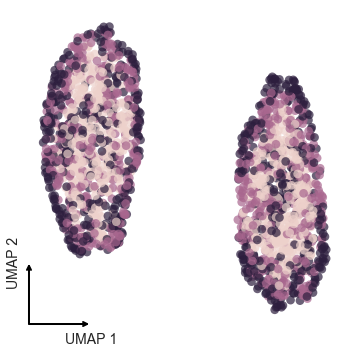

In [36]:
DR_plot(dim_name='UMAP').plot(gauss.obsm['X_umap'], color=gauss.obs['class'])

In [37]:
# perform t-SNE
%time sc.tl.tsne(gauss, use_rep='X', perplexity=30, random_state=18)

CPU times: user 9.07 s, sys: 22.9 ms, total: 9.1 s
Wall time: 9.04 s


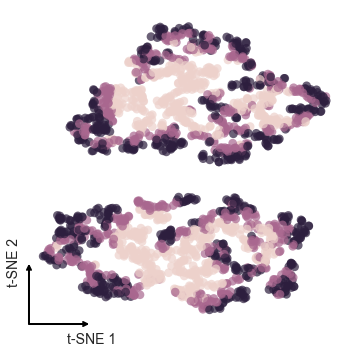

In [38]:
DR_plot(dim_name='t-SNE').plot(gauss.obsm['X_tsne'], color=gauss.obs['class'])

In [39]:
%time pca_corr, pca_EMD, pca_knnP = structure_preservation_sc(gauss, latent='X_pca', native='X', k=30)
print('R: {}\nEMD: {}\nKnn %: {}'.format(round(pca_corr[0],4), round(pca_EMD,4), round(pca_knnP,4)))

Calculating unique distances for native space, X
Calculating unique distances for latent space, X_pca
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
30-nearest neighbor calculation for native space, X
30-nearest neighbor calculation for latent space, X_pca
Determining nearest neighbor preservation
Done!
CPU times: user 2.16 s, sys: 236 ms, total: 2.4 s
Wall time: 954 ms
R: 0.9981
EMD: 0.0116
Knn %: 97.651


In [40]:
%time tsne_corr, tsne_EMD, tsne_knnP = structure_preservation_sc(gauss, latent='X_tsne', native='X', k=30)
print('R: {}\nEMD: {}\nKnn %: {}'.format(round(tsne_corr[0],4), round(tsne_EMD,4), round(tsne_knnP,4)))
final_distance_stats['Gauss']['R']['t-SNE'], final_distance_stats['Gauss']['EMD']['t-SNE'], final_distance_stats['Gauss']['Knn Pres.']['t-SNE'] = tsne_corr[0], tsne_EMD, tsne_knnP

Calculating unique distances for latent space, X_tsne
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
30-nearest neighbor calculation for latent space, X_tsne
Determining nearest neighbor preservation
Done!
CPU times: user 1.54 s, sys: 168 ms, total: 1.71 s
Wall time: 857 ms
R: 0.8165
EMD: 0.1194
Knn %: 97.9992


In [41]:
%time umap_corr, umap_EMD, umap_knnP = structure_preservation_sc(gauss, latent='X_umap', native='X', k=30)
print('R: {}\nEMD: {}\nKnn %: {}'.format(round(umap_corr[0],4), round(umap_EMD,4), round(umap_knnP,4)))
final_distance_stats['Gauss']['R']['UMAP'], final_distance_stats['Gauss']['EMD']['UMAP'], final_distance_stats['Gauss']['Knn Pres.']['UMAP'] = umap_corr[0], umap_EMD, umap_knnP

Calculating unique distances for latent space, X_umap
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
30-nearest neighbor calculation for latent space, X_umap
Determining nearest neighbor preservation
Done!
CPU times: user 1.58 s, sys: 180 ms, total: 1.76 s
Wall time: 843 ms
R: 0.961
EMD: 0.0442
Knn %: 97.7664


<Figure size 288x288 with 0 Axes>

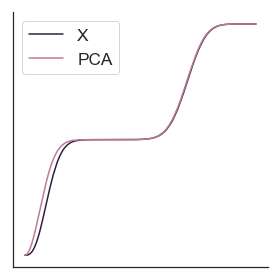

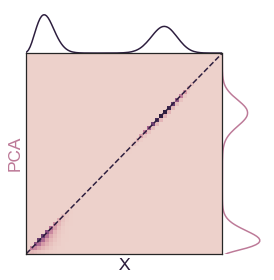

In [42]:
plt.figure(figsize=(4,4))
SP_plot(gauss.uns['X_norm_distances'], gauss.uns['X_pca_norm_distances'], labels=['X','PCA']).plot_cumulative_distributions()
SP_plot(gauss.uns['X_norm_distances'], gauss.uns['X_pca_norm_distances'], labels=['X','PCA']).joint_plot_distance_correlation()

<Figure size 288x288 with 0 Axes>

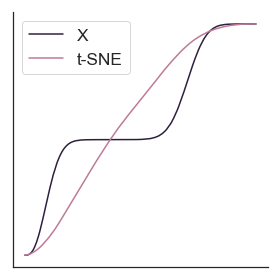

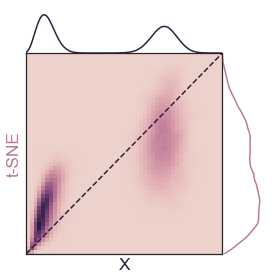

In [43]:
plt.figure(figsize=(4,4))
SP_plot(gauss.uns['X_norm_distances'], gauss.uns['X_tsne_norm_distances'], labels=['X','t-SNE']).plot_cumulative_distributions()
SP_plot(gauss.uns['X_norm_distances'], gauss.uns['X_tsne_norm_distances'], labels=['X','t-SNE']).joint_plot_distance_correlation()

<Figure size 288x288 with 0 Axes>

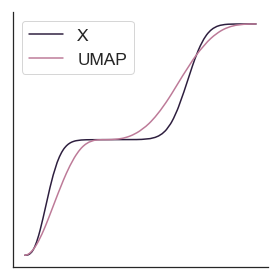

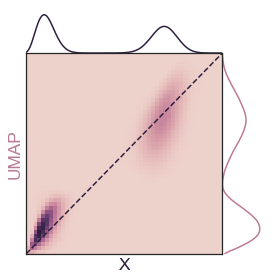

In [44]:
plt.figure(figsize=(4,4))
SP_plot(gauss.uns['X_norm_distances'], gauss.uns['X_umap_norm_distances'], labels=['X','UMAP']).plot_cumulative_distributions()
SP_plot(gauss.uns['X_norm_distances'], gauss.uns['X_umap_norm_distances'], labels=['X','UMAP']).joint_plot_distance_correlation()

---

In [76]:
stats_gauss = pd.DataFrame(final_distance_stats['Gauss'])
stats_gauss['Dataset'] = 'Gaussian'

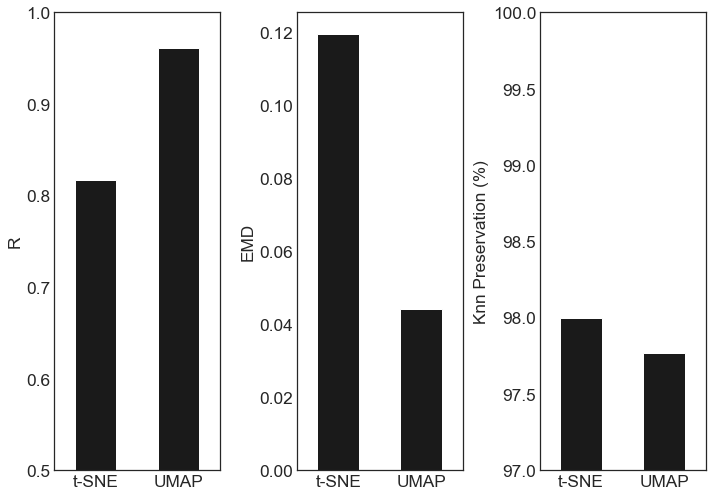

In [81]:
with plt.style.context('seaborn-white'):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,7))
    stats_gauss[['R']].plot(ax=axes[0],kind='bar', legend=False, color='k')
    stats_gauss[['EMD']].plot(ax=axes[1],kind='bar', legend=False, color='k')
    stats_gauss[['Knn Pres.']].plot(ax=axes[2],kind='bar', legend=False, color='k')
    axes[0].set_ylabel('R', fontsize='xx-large')
    axes[1].set_ylabel('EMD', fontsize='xx-large')
    axes[0].set_ylim([0.5, 1])
    axes[2].set_ylim([97, 100])
    axes[2].set_ylabel('Knn Preservation (%)', fontsize='xx-large')
    axes[0].tick_params(labelsize='xx-large', rotation=0)
    axes[1].tick_params(labelsize='xx-large', rotation=0)
    axes[2].tick_params(labelsize='xx-large', rotation=0)
    plt.tight_layout()
    plt.savefig('outputs/plots/doublegauss_stats.png', dpi=1000)